In [1]:
import findspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime
from pyspark.sql import Row
import pyspark.sql.functions as f

import pyspark.sql.types as t

import pyspark.ml.feature as feat

import numpy as np
import pandas as pd

# Pipeline
from pyspark.ml import Pipeline, PipelineModel

# Machine learning
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Cross validation 
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [5]:
# import os
# import sys

# os.environ['PYSPARK_PYTHON'] = sys.executable
# os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

# About Dataset
Build a clustering model for Customer Segmentation.

In [3]:
SparkContext.setSystemProperty(key='spark.hadoop.dfs.client.use.datanode.hostname',value='true')

In [4]:
sc =SparkContext()

In [5]:
sc.setLogLevel("ERROR")

In [6]:
spark = SparkSession(sc)

In [7]:
df = spark.read.csv('../DATA/rfm_data.csv',inferSchema=True,header=True)

In [8]:
df.show(5)

+----------+-------+---------+--------+---+---+---+-------+---------+--------+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|   label|
+----------+-------+---------+--------+---+---+---+-------+---------+--------+
|     12346|    325|        1| 77183.6|  1|  1|  4|    114|        6|    rich|
|     12347|      1|        7|  4310.0|  4|  4|  4|    444|       12|     VIP|
|     12348|     74|        4| 1797.24|  2|  3|  4|    234|        9|    rich|
|     12349|     18|        1| 1757.55|  4|  1|  4|    414|        9|   other|
|     12350|    309|        1|   334.4|  1|  1|  2|    112|        4|inactive|
+----------+-------+---------+--------+---+---+---+-------+---------+--------+
only showing top 5 rows



# Overview

In [9]:
df.show(1,vertical=False,truncate=True)
df.printSchema()
print(f'There are {df.count()} rows and {len(df.columns)} columns in dataframe')

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|     12346|    325|        1| 77183.6|  1|  1|  4|    114|        6| rich|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
only showing top 1 row

root
 |-- CustomerID: string (nullable = true)
 |-- recency: integer (nullable = true)
 |-- frequency: integer (nullable = true)
 |-- monetary: double (nullable = true)
 |-- R: integer (nullable = true)
 |-- F: integer (nullable = true)
 |-- M: integer (nullable = true)
 |-- rfm_seg: integer (nullable = true)
 |-- rfm_score: integer (nullable = true)
 |-- label: string (nullable = true)

There are 5766 rows and 10 columns in dataframe


## check null

In [10]:
df.select([f.count(f.when(f.isnan(c), c)).alias(c) for c in df.columns]).show()

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|         0|      0|        0|       0|  0|  0|  0|      0|        0|    0|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+



In [11]:
df.select([f.count(f.when(f.isnull(c), c)).alias(c) for c in df.columns]).show()

+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|CustomerID|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|label|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+
|         0|      0|        0|       0|  0|  0|  0|      0|        0|    0|
+----------+-------+---------+--------+---+---+---+-------+---------+-----+



## Descirble data

In [12]:
cat_col = ['R','F','M','rfm_seg','label']
cat_col

['R', 'F', 'M', 'rfm_seg', 'label']

In [13]:
numeric_col = [k for k,v in dict(df.dtypes).items() if not (v=='string' or v=='timestamp') and not k in cat_col]
#numeric_col = numeric_col[2:] 
numeric_col

['recency', 'frequency', 'monetary', 'rfm_score']

In [14]:
df.select(numeric_col).describe().show()

+-------+------------------+------------------+----------------+------------------+
|summary|           recency|         frequency|        monetary|         rfm_score|
+-------+------------------+------------------+----------------+------------------+
|  count|              5766|              5766|            5766|              5766|
|   mean|116.50693721817551|3.4616718695802984|1849.92794658342|               7.5|
| stddev|111.29927870457249| 6.824640696687705|7919.02686104613|2.7233690425446904|
|    min|                 0|                 1|            0.42|                 3|
|    max|               373|               209|       280206.02|                12|
+-------+------------------+------------------+----------------+------------------+



## Category data

### Check distinct values

In [15]:
df.select([f.count_distinct(c).alias(c) for c in df.columns if c not in numeric_col]).show()

+----------+---+---+---+-------+-----+
|CustomerID|  R|  F|  M|rfm_seg|label|
+----------+---+---+---+-------+-----+
|      5766|  4|  4|  4|     63|    8|
+----------+---+---+---+-------+-----+



- Remove some columns is not appropriate for model: `CustomerID` because it can cause **the curse of dimensionality**

In [16]:
df_final = df.drop('CustomerID')

### Check top5 disticnt value count of each category columns in df 

In [17]:
for col in cat_col:
    (df.groupby(col).count()
     .withColumn('Normalize',(f.col('count')/df_final.count()))
     .orderBy(f.col('count').desc())
     .show(5,vertical=False,truncate=False))

+---+-----+------------------+
|R  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+---+-----+------------------+
|F  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+---+-----+------------------+
|M  |count|Normalize         |
+---+-----+------------------+
|1  |1442 |0.2500867152271939|
|4  |1442 |0.2500867152271939|
|3  |1441 |0.2499132847728061|
|2  |1441 |0.2499132847728061|
+---+-----+------------------+

+-------+-----+-------------------+
|rfm_seg|count|Normalize          |
+-------+-----+-------------------+
|444    |585  |0.10145681581685743|
|121    |290  |0.05029483177245924|
|111    |281  |0.04873395768296913|
|344    |257  |0.04457162677766216|
|

In [18]:
df_final.show()

+-------+---------+--------+---+---+---+-------+---------+---------+
|recency|frequency|monetary|  R|  F|  M|rfm_seg|rfm_score|    label|
+-------+---------+--------+---+---+---+-------+---------+---------+
|    325|        1| 77183.6|  1|  1|  4|    114|        6|     rich|
|      1|        7|  4310.0|  4|  4|  4|    444|       12|      VIP|
|     74|        4| 1797.24|  2|  3|  4|    234|        9|     rich|
|     18|        1| 1757.55|  4|  1|  4|    414|        9|    other|
|    309|        1|   334.4|  1|  1|  2|    112|        4| inactive|
|     35|        8| 2506.04|  3|  4|  4|    344|       11|      VIP|
|    203|        1|    89.0|  1|  1|  1|    111|        3| inactive|
|    231|        1|  1079.4|  1|  1|  3|    113|        5|    other|
|    213|        1|   459.4|  1|  1|  2|    112|        4| inactive|
|     22|        3| 2811.43|  4|  3|  4|    434|       11|      VIP|
|     32|        1| 6207.67|  3|  1|  4|    314|        8|    other|
|      1|        2| 1168.06|  4|  

## Numeric data

## Check skewness

In [19]:
df_final.select([f.skewness(c) for c in numeric_col]).show()

+------------------+-------------------+------------------+-------------------+
| skewness(recency)|skewness(frequency)|skewness(monetary)|skewness(rfm_score)|
+------------------+-------------------+------------------+-------------------+
|0.8125804966719041| 13.353943773741968|21.428859876655775|0.14789449526230464|
+------------------+-------------------+------------------+-------------------+



There is a high skewness => use MinMax scaler

## Coeffiecient Correlation 

C:\ProgramData\Anaconda3\envs\env39\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


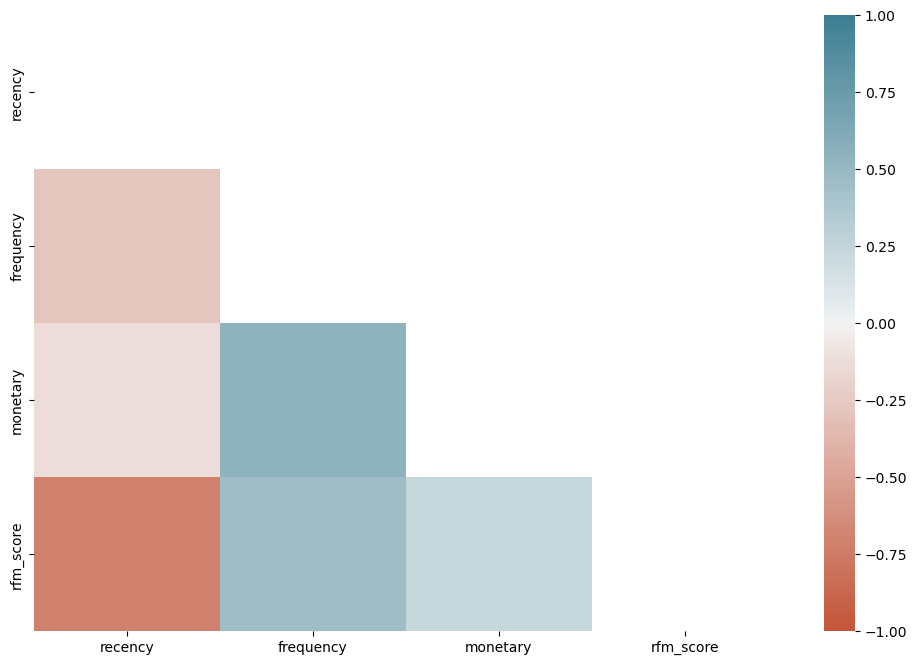

In [25]:
corr = df_final.select([c for c in df_final.columns if c not in cat_col]).toPandas().select_dtypes('number').corr()
mask_ut=np.triu(np.ones(corr.shape)).astype(bool)
plt.figure(figsize=(12,8))
sns.heatmap(corr,
            annot=True,
            vmin=-1,center=0,vmax=1,
            cmap=sns.diverging_palette(20, 220, n=200),
            mask=mask_ut)
plt.show()

# Preprocessing